### ⚠️ Roteiro para executar códigos do notebook no Google Colab(oratory)_


**PASSO 1:** Acessar https://colab.research.google.com/ $\to$ `Upload` $\to$ `escolher arquivo .ipynb`

**PASSO 2:** `Barra lateral esquerda` $\to$ `Icone de arquivo` $\to$ `Icone de upload` $\to$ `escolher arquivo auxiliar` (ex. `aux.py`)

**PASSOS 3:** ver célula a seguir...

In [ ]:
#### PASSO 3: INSTALAR versão MXNET
#### Descomente a linha abaixo e execute

#!pip install mxnet==1.8.0 (ou 1.7.0.post1)

# Avaliar para Selecionar (o melhor) modelo treinado


A fim de se sair bem na prova de um concurso é importante **variar/criar técnicas de estudo**. Por exemplo, a pessoa pode variar através de:
- ler em voz alta
- copiar conteúdo no caderno
- ouvir/ver gravações de aulas
- criar analogias
- ...

Cada uma das inúmeras possíveis combinações acima gera o que chamamos de **MODELO**.

Após gerar um modelo desses, poderíamos então testa-lo (nos testar) através da resolução de questões de provas antigas do mesmo concurso, por exemplo. Mas o **IDEAL** é que **não tenhamos usados essas mesmas questões durante o estudo**. Se formos mal, modifcamos o modelo; ou seja, estudamos de outra maneira, outra combinação e nos testamos de novo... e de novo... e de novo até que tenhamos o **modelo VENCEDOR**: isso é, teoricamente, **o máximo que poderíamos estar preparados** para o concurso!!!


Uma máquina deveria fazer a mesma coisa para criar variados modelos e testa-los. Com MLP, por exemplo, é possível variar:
- números de camadas ocultas;
- variadas funções de ativação da camada oculta;
- taxas de aprendizado;
- batches;
- ...

Essa lista ilustra os chamados **HIPERPARÂMETROS DE TREINAMENTO** (objetivo é descobrir os melhores valores).

Durante a criação de cada modelo, temos o **TREINAMENTO** e o **ERRO DE TREINAMENTO**

A auto-avaliação para cada modelo gerado se chama **VALIDAÇÃO** (e temos o **ERRO DE VALIDAÇÃO**)

A prova final (concurso) se chama **TESTE** (e temos o **ERRO DO TESTE**)

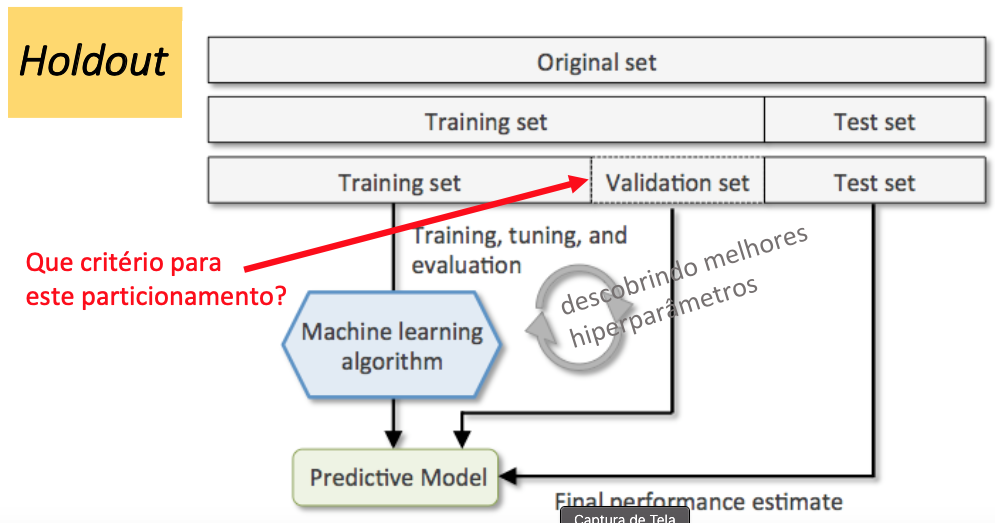

## Quando há escassez de dados para validação... Validação Cruzada

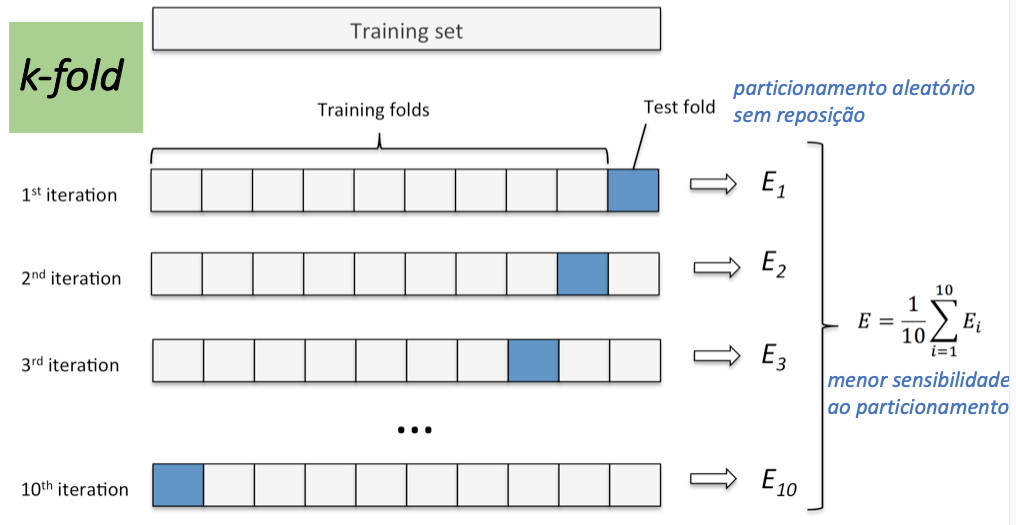

## OVERFITTING e UNDERFITTING


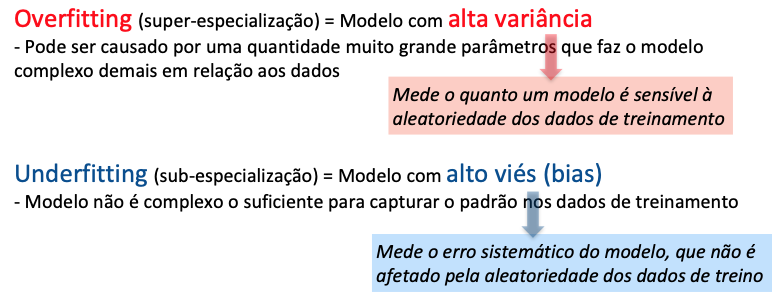

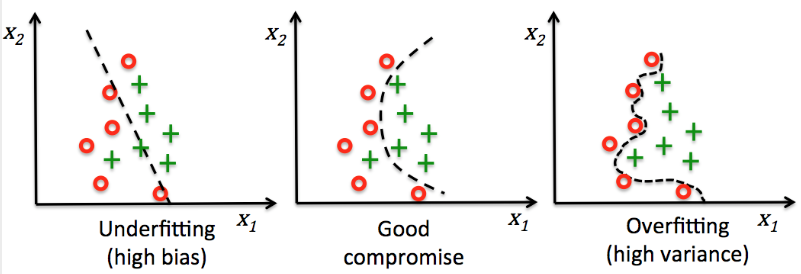

### Naturalmente existe aí um _tradeoff_

## REFLEXÃO: complexidade dos modelos

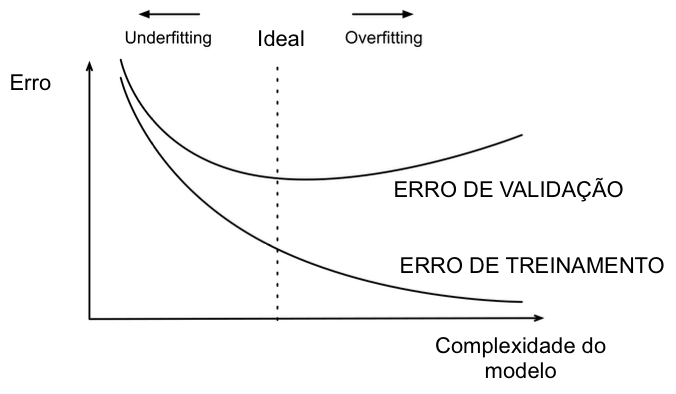


## REFLEXÃO: complexidade dos dados


Para um MODELO (fixado):

$\downarrow$ amostras no dataset $\implies$ $\uparrow$ overfitting

$\uparrow$  amostras no dataset $\implies$ $\downarrow$ ERRO DE VALIDAÇÃO (em geral, quanto mais dados, melhor) 


Para um PROBLEMA/TAREFA específica:

$\uparrow$ amostras no dataset $\implies$ $\uparrow$ modelo mais complexo $>$ modelo mais simples

$\downarrow$ amostras no dataset $\implies$ modelos mais simples $>$ modelos mais complexos

**ATENÇÃO**: para muitos problemas, o aprendizado profundo só supera os modelos mais simples quando **milhares (ou milhões) de exemplos** de treinamento **estão disponíveis**. 

Abundância de dados (Internet, Redes sociais, sensores, etc.) $\implies$ **Sucesso atual do APRENDIZADO PROFUNDO**

# EXEMPLO: Regressão polinomial


$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon $$

onde 

$\epsilon \sim \mathcal{N}(0,0.1)$

_obs: características são reescaladas pelo fatorial a fim de se evitar valores gigantes para graus altos._

In [13]:
import math
from mxnet import gluon, np, npx
from mxnet.gluon import nn
import aux as aux

npx.set_np()

### Gerando o dataset

In [14]:
max_degree = 20  #características = grau máximo do polinômio
n_train, n_test = 200, 200  
true_w = np.zeros(max_degree)  
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [15]:
# imprimindo os dois primeiros exemplos do dataset gerado
# cada exemplo contém: constante (grau zero) (bias), 20 caracacterísticas (grau 1 à 20), 1 valor dependente (y)
features[:2], poly_features[:2, :], labels[:2]

(array([[-0.2994183 ],
        [ 0.57274216]]),
 array([[ 1.0000000e+00, -2.9941830e-01,  4.4825658e-02, -4.4738743e-03,
          3.3488995e-04, -2.0054436e-05,  1.0007776e-06, -4.2807304e-08,
          1.6021612e-09, -5.3301818e-11,  1.5959541e-12, -4.3441623e-14,
          1.0839347e-15, -2.4965376e-17,  5.3393506e-19, -1.0657994e-20,
          1.9944990e-22, -3.5128800e-24,  5.8434471e-26, -9.2086048e-28],
        [ 1.0000000e+00,  5.7274216e-01,  1.6401680e-01,  3.1313110e-02,
          4.4835848e-03,  5.1358761e-04,  4.9025544e-05,  4.0112855e-06,
          2.8717903e-07,  1.8275504e-08,  1.0467153e-09,  5.4499811e-11,
          2.6011949e-12,  1.1460108e-13,  4.6883481e-15,  1.7901430e-16,
          6.4080648e-18,  2.1589229e-19,  6.8694789e-21,  2.0707579e-22]]),
 array([4.3335896, 5.546256 ]))

### Definição da função de treinamento com Mini-Batch SGD

In [16]:
# Função de avaliação do erro
def evaluate_loss(net, data_iter, loss):  #@save
    metric = aux.Accumulator(2)  # Soma dos erros, no. de exemplos
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(l.sum(), l.size)
    return metric[0] / metric[1]

In [17]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = gluon.loss.L2Loss()
    net = nn.Sequential()
    net.add(nn.Dense(1, use_bias=False))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = aux.load_array((train_features, train_labels), batch_size)
    test_iter = aux.load_array((test_features, test_labels), batch_size,
                               is_train=False)
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': 0.01})
    animator = aux.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        aux.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('pesos:', net[0].weight.data().asnumpy())

### _Fitting_ adequado: 4 primeiras dimensões (graus do polinômio: 0,1,2 e 3 => cúbico)

Modelo adequado.

pesos: [[ 4.9988565  1.1992986 -3.3877978  5.583302 ]]


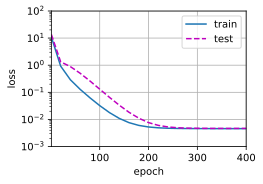

In [18]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

### _Underfitting_ : 2 primeiras dimensões (graus do polinômio: 0 e 1 => linear)

Modelo muito simples para reconhecer o padrão do polinômio original.

pesos: [[3.5069118 3.401625 ]]


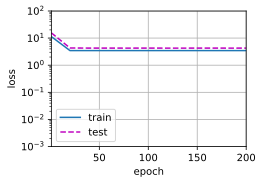

In [19]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:], num_epochs=200)

### _Overfitting_ : todos os 20 graus gerados no dataset

Não há dados suficientes para aprender que os coeficientes de grau mais elevado devem ter valores próximos/iguais à zero. Assim, o modelo fica muito suscetível ao ruído nos dados de treinamento. 

pesos: [[ 4.9527683   1.3422681  -3.1951408   4.8926907  -0.40907922  1.712314
   0.10044957  0.27059743 -0.01613248  0.09467275 -0.01332428  0.06727838
  -0.01334838  0.03786281  0.03791413 -0.01513136 -0.04745899  0.0311126
  -0.03377711  0.01601166]]


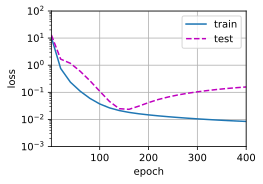

In [20]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:])#, num_epochs=1500)

# Como resolver o _tradoff_ viés-variância?

## como lidar com o _overfitting_ (principalmente)?

1. Coletar mais dados ==> muitas vezes é beeeem difícil!
2. Limitar o número de características ==> podemos prejudicar a tarefa de reconhecimento real do padrão "escondido"
3. ...

## ...Regularização $L_2$

### Introduzir informação adicional na função de erro para penalizar valores muito altos de pesos.

Recapitulando a função de erro na Regressão Linear:
$$L(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2$$

Nova função de erro da Regressão Linear com regularização $L_2$ (_ridge regression_):
$$L(\mathbf{w}, b) + \frac{\lambda}{2} \|\mathbf{w}\|^2$$

onde,

$\lambda$ é uma constante (mais um hiperparâmetro de controle do treinamento).  

### Como fica a atualização dos pesos?

Recapitulando...

$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b)$$

E agora...

\begin{aligned}
\mathbf{w} & \leftarrow \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right) - \eta\lambda\mathbf{w}.
\end{aligned}

Ou seja...

\begin{aligned}
\mathbf{w} & \leftarrow \left(1- \eta\lambda \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right).
\end{aligned}


### Intuição/Reflexão sobre o comportamento dos pesos (_Weight Decay_)

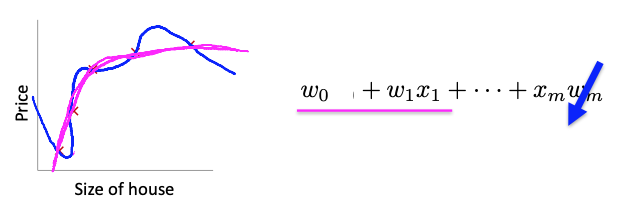

**ATENÇÃO:** é possível usar outras formas de regularização. **$L_1$**, por exemplo, também é bem usada (na Regressão Linear, se chama _lasso regression_). A diferença, na prática, é que **$L_1$ causa uma penalidade mais agressiva o que tende a zerar os graus maiores**, enquanto **$L_2$ tende a distribuir essa penalidade entre todos os graus**. Na prática, $L_1$ provoca redução de dimensionalidade; ou seja, redução de características.

### Questões

#### 1. Se $\lambda$ = 0?  
#### 2. Se $\lambda$ for gigantesco?

# E quando o _tradeoff_ viés-variância não é o problema?

**Modelos menos complexos (lineares, por exemplo) sofrem bastante com esse _tradeoff_** porque não levam tanto em conta as dependências entre as características; consideram ingenuamente que elas não existem. Para cada característica, um modelo linear atribui um peso positivo ou negativo, ignorando o contexto. Normalmente, então, quando temos muito mais exemplos na base do que características (dimensões), as chances de overfitting são muito baixas.


**As redes neurais profundas**, entretanto, não consideram cada característica isoladamente. Elas **podem aprender interações entre grupos de características**. Por exemplo, elas podem inferir que os termos "Nigeria" e "Western Union" aparecendo juntas em um e-mail indicam spam, mas se vierem separadamente, não. **Mesmo quando temos muito mais exemplos do que características**, as redes neurais profundas **são capazes de superespecializar (overfitting)**. 

## Refletindo sobre outras soluções...

**Um bom modelo deve ser robusto sob pequenas mudanças nas entradas!**

1995, Christopher Bishop ==> adicionar ruídos nas entradas é equivalente à Regularização de Tikhonov

2014, Srivastava et al. ==> propuseram aplicar a mesma ideia para as camadas internas (escondidas): ruído é injetado em cada camada da rede antes de calcular a camada subseqüente durante o treinamento.

## Dropout
### Técnica padrão para o treinamento de redes neurais profundas

Literalmente, abandona-se alguns neurônios durante o treinamento; em cada iteração, o abandono padrão consiste em zerar um percentual de nós em cada camada antes de calcular a camada subseqüente.

#### Para cada nó interno...

\begin{split}\begin{aligned}
h' =
\begin{cases}
    0 & \text{ with probability } p \\
    \frac{h}{1-p} & \text{ otherwise}
\end{cases}
\end{aligned}\end{split}



\begin{split}\begin{aligned}
    \mathbf{H} & = \sigma(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}), \\
    \mathbf{H'} & = dropout(\mathbf{H}), \\
    \mathbf{O} & = \mathbf{H'}\mathbf{W}^{(2)} + \mathbf{b}^{(2)},\\
    \mathbf{Y} & = softmax(\mathbf{O})
\end{aligned}\end{split}.

## Droput com `mxnet.gluon`

#### ESTUDO DE CASO: dataset _Fashion-MNIST_

In [21]:
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
import aux as aux

npx.set_np()

batch_size = 256
train_iter, test_iter = aux.load_data_fashion_mnist(batch_size)

### ARQUITETURA NEURONAL

**Entrada** = 784 neurônios (características da Fashion-MNIST)  
**Escondida 1** = 256 neurônios  
**Escondida 2** = 256 neurônios  
**Saída** = 10 neurônios (classes da Fashion-MNIST)  
**Função de ativação** = ReLU  
**Dropout 1**: em Escondida 1 com prob 20%  
**Dropout 2**: em Escondida 2 com prob 50%  
**Épocas**: 10  
**Taxa de aprendizado**: 0.5   
**Função de erro**: Softmax Cross Entropy  

In [22]:
dropout1, dropout2 = 0.2, 0.5
num_epochs, lr  = 10, 0.5
loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [23]:
hidden_1 = 256 #neurônios na 1a camada escondida
hidden_2 = 256 #neurônios na 2a camada escondida
output = 10 #neurônios na saída
net = nn.Sequential()
net.add(
    nn.Dense(hidden_1, activation="relu"),
    nn.Dropout(dropout1), nn.Dense(hidden_2, activation="relu"), #Primeiro dropout
    nn.Dropout(dropout2), nn.Dense(10)) #Segundo dropout
net.initialize(init.Normal(sigma=0.01))

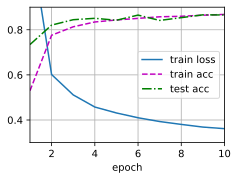

In [24]:
# Treinamento e teste do modelo
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
aux.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# Referências para estudo

## Seções 4.4, 4.5 e 4.6 de [Dive into Deep Learning](https://d2l.ai/index.html)